In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
from google.colab import drive
drive.mount('/content/drive')
# Load observed data
data=pd.read_csv('/content/drive/MyDrive/spring2025/Modeling_Lab/[HW4]_Practical_class_4/LV_data.csv')
t_data = data['Time'].values
x_data = data['Prey'].values
y_data = data['Predator'].values
z0=[x_data[0],y_data[0]]
z0=np.array(z0)
# Define the Lotka-Volterra ODE system
def lotka_volterra(t, z, α, β, γ, δ):
  x, y = z
  return [α*x - β*x*y,

          δ*x*y - γ*y]

Mounted at /content/drive


In [3]:
# MSE objective function to be optimized
def compute_error(params):
  α, β, γ, δ=params
  sol=solve_ivp(lotka_volterra,t_span=(t_data[0],t_data[-1]),y0=z0,args=(α,β,γ,δ),t_eval=t_data)
  if not sol.success:
    return np.inf
  x_sim,y_sim=sol.y
  return np.mean((x_sim-x_data)**2+(y_sim-y_data)**2)


In [4]:
def simulated_annealing(initial_params, bounds, T0=1.0, cooling_rate=0.99, max_iter=5000, step_size=0.05):
    current_params = np.array(initial_params)
    current_error = compute_error(current_params)
    best_params = current_params.copy()
    best_error = current_error
    T = T0

    for i in range(max_iter):
      # Propose new parameters
      proposal = current_params + np.random.uniform(-step_size, step_size, size=4)
      #Force each proposed parameter to stay within the allowed range, so the algorithm doesn’t go out of bounds
      proposal = np.clip(proposal, [b[0] for b in bounds], [b[1] for b in bounds])

      # error of proposal
      proposal_error=compute_error(proposal)

      # are we accepting or not
      if proposal_error-current_error <0 or np.exp(-(proposal_error-current_error)/T) >np.random.rand():
        current_params=proposal
        current_error=proposal_error
        if current_error< best_error:
          best_params=current_params
          best_error=current_error

      T*=cooling_rate
    return best_params,best_error


Best parameters: [0.54752532 0.02811854 0.84318821 0.02655793]
Minimum error: 36.11127717901987


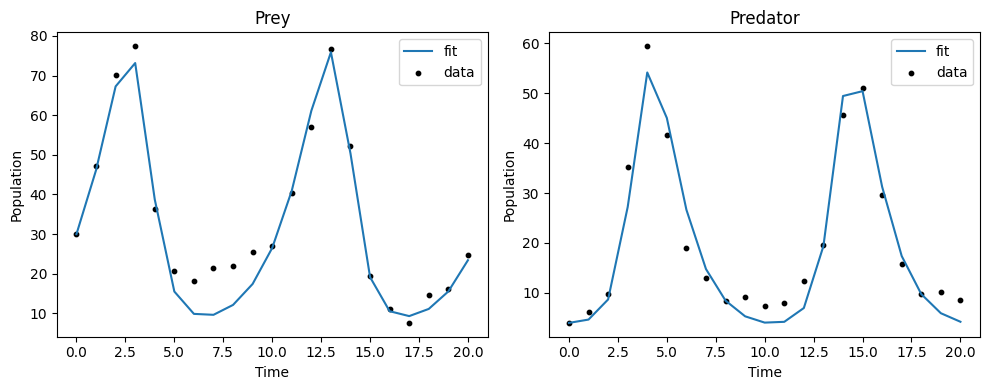

In [5]:

#  Run SA with constraints ---
bounds = [(0.01, 2), (0.001, 0.22), (0.01, 2), (0.001, 0.22)]
initial_guess = [0.54752532, 0.02811854, 0.84318821, 0.02655793]
best_params, best_error = simulated_annealing(initial_guess, bounds)

print("Best parameters:", best_params)
print("Minimum error:", best_error)

# --- 6. Plot final result ---
sol = solve_ivp(lotka_volterra, (t_data[0], t_data[-1]), z0, args=tuple(best_params), t_eval=t_data)
x_sim, y_sim = sol.y

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(t_data, x_sim, label='fit'); ax1.scatter(t_data, x_data, c='k', s=10, label='data')
ax2.plot(t_data, y_sim, label='fit'); ax2.scatter(t_data, y_data, c='k', s=10, label='data')
ax1.set_title("Prey"); ax2.set_title("Predator")
for ax in (ax1, ax2): ax.set_xlabel("Time"); ax.set_ylabel("Population"); ax.legend()
plt.tight_layout(); plt.show()